In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    adjusted_rand_score
)
from sklearn.decomposition import PCA
import json
from pathlib import Path

RANDOM_STATE = 42
N_INIT = 10
DATA_DIR = "data"

# Настройки PCA: None (не использовать) или число компонент (например, 30)
pca_dim = 30

# Диапазон K для KMeans
kmeans_ks = list(range(2, 21))
# kmeans_ks = [2]

# Сетка для DBSCAN: eps и min_samples
# eps зависит от масштаба данных – после scaling обычно eps ~ 0.5..5 (но это очень примерно).
dbscan_eps = [1.5, 2.0, 2.5, 3.0, 3.5]
dbscan_min_samples = [3, 5, 10]
# dbscan_eps = [2.0]
# dbscan_min_samples = [2]

# Agglomerative: число кластеров и linkage (для sklearn Agglomerative: 'ward' требует euclidean)
agg_ks = list(range(2, 8))
agg_linkages = ["ward", "complete", "average"]
# agg_ks = [2]
# agg_linkages = ["ward"]

print("Config:")
print(" pca_dim:", pca_dim)
print(" kmeans_ks:", (kmeans_ks[0], "...", kmeans_ks[-1]))
print(" dbscan eps:", dbscan_eps)
print(" dbscan min_samples:", dbscan_min_samples)
print(" agg ks:", (agg_ks[0], "...", agg_ks[-1]))
print(" agg linkages:", agg_linkages)

config = {
    "pca_dim:": pca_dim,
    "kmeans_ks:": (kmeans_ks[0], "...", kmeans_ks[-1]),
    "dbscan eps:": dbscan_eps,
    "dbscan min_samples:": dbscan_min_samples,
    "agg ks:": (agg_ks[0], "...", agg_ks[-1]),
    "agg linkages:": agg_linkages,
}
with open("artifacts/config.json", "w") as f:
    json.dump(config, f, indent=4)

Config:
 pca_dim: 30
 kmeans_ks: (2, '...', 20)
 dbscan eps: [1.5, 2.0, 2.5, 3.0, 3.5]
 dbscan min_samples: [3, 5, 10]
 agg ks: (2, '...', 7)
 agg linkages: ['ward', 'complete', 'average']


In [41]:
df_array = []
file_names = ["S07-hw-dataset-01.csv", "S07-hw-dataset-02.csv", "S07-hw-dataset-03.csv"]

for f_name in file_names:
    df = pd.read_csv(f"{DATA_DIR}/{f_name}")
    df_array.append(df)

def check_dfs():
    for i in range(0, len(file_names)):
        print("\n",file_names[i])
        print("HEAD\n", df_array[i].head())
        print("\nINFO\n", df_array[i].info())
        print("\nDESCRIBE\n", df_array[i].describe())
        print("\nMISS\n", df_array[i].isna().sum())
        
check_dfs()


 S07-hw-dataset-01.csv
HEAD
    sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        120

In [42]:
# Метрики silhouette, davies_bouldin, calinski_harabasz
def safe_cluster_metrics(X, labels):
    """Считает метрики; возвращает None, если метрика неприменима."""
    unique = np.unique(labels)
    # Нужно минимум 2 кластера
    if len(unique) < 2:
        return None

    # Нельзя, чтобы все точки были в одном кластере
    if len(unique) == 1:
        return None

    # silhouette требует, чтобы все кластеры имели >1 точки (часто, но не всегда)
    # В sklearn silhouette_score может падать, если какой-то кластер пуст/особый.
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = None

    try:
        db = float(davies_bouldin_score(X, labels))
    except Exception:
        db = None

    try:
        ch = float(calinski_harabasz_score(X, labels))
    except Exception:
        ch = None

    return {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

In [43]:
# препроцессинг (масштабирование числовых признаков)
def preprocessing(df: pd.DataFrame):
    cols = [i for i in df.columns if i != "sample_id"]
    X = df[cols]
    preprocess = Pipeline([
        ("scaler", StandardScaler())
    ])
    return preprocess.fit_transform(X)
    
# X_df1 = preprocessing(df_array[0])
# X_df2 = preprocessing(df_array[1])
# X_df3 = preprocessing(df_array[2])

# X_df_list = [X_df1, X_df2, X_df3]

datasets = []
for i in range(3):
    sample_id = df_array[i]["sample_id"]
    X_df = preprocessing(df_array[i])
    datasets.append({
        "file_name": file_names[i],
        "X": X_df,
        "sample_id": sample_id
    })

In [44]:
# KMeans
def eval_kmeans_grid(X_feat, ks, rs=RANDOM_STATE):
    results = []
    for k in ks:
        try:
            model = KMeans(n_clusters=k, random_state=rs, n_init="auto")
        except TypeError:
            model = KMeans(n_clusters=k, random_state=rs, n_init=10)

        labels = model.fit_predict(X_feat)
        metrics = safe_cluster_metrics(X_feat, labels)

        results.append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels,
            "metrics": metrics,
            "inertia": float(model.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0,
        })
    return results

#kmeans_results = eval_kmeans_grid(X_df1, kmeans_ks)
#len(kmeans_results), kmeans_results[0]["params"], kmeans_results[-1]["params"]

In [45]:
# Графики KMeans и Agg 
# График silhouette по k (если silhouette считалась)
def draw_kmean_graphs(kmeans_results, df_name = None):
    ks = [r["params"]["k"] for r in kmeans_results]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results]
    
    plt.figure(figsize=(7, 4))
    plt.plot(ks, sil, marker="o")
    plt.title("KMeans: silhouette vs k")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.grid(True, alpha=0.25)
    if df_name is not None:
        plt.savefig(f"artifacts/figures/kmean_k_sil_{df_name}.png")
    plt.show()
    
    # Инерция (elbow) – как эвристика
    inertia = [r["inertia"] for r in kmeans_results]
    plt.figure(figsize=(7, 4))
    plt.plot(ks, inertia, marker="o")
    plt.title("KMeans: inertia vs k (elbow heuristic)")
    plt.xlabel("k")
    plt.ylabel("inertia")
    plt.grid(True, alpha=0.25)
    if df_name is not None:
        plt.savefig(f"artifacts/figures/kmean_k_inertia_{df_name}.png")
    plt.show()

# Силуэт по k для разных linkage (на одном графике – удобно для сравнения)
def draw_agg_graph(agg_results, agg_linkages, df_name = None):
    plt.figure(figsize=(7, 4))
    
    for linkage_name in agg_linkages:
        subset = [r for r in agg_results if r["params"]["linkage"] == linkage_name]
        subset = sorted(subset, key=lambda r: r["params"]["k"])
        ks = [r["params"]["k"] for r in subset]
        sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in subset]
        plt.plot(ks, sil, marker="o", label=linkage_name)
    
    plt.title("Agglomerative: silhouette vs k (by linkage)")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.grid(True, alpha=0.25)
    plt.legend()
    if df_name is not None:
        plt.savefig(f"artifacts/figures/agg_k_inertia_{df_name}.png")
    plt.show()

In [46]:
def pick_best_by_silhouette(results):
    best = None
    best_score = -np.inf
    for r in results:
        m = r["metrics"]
        if m is None:
            continue
        s = m["silhouette"]
        if s is None:
            continue
        if s > best_score:
            best_score = s
            best = r
    return best, best_score

#best_kmeans, best_kmeans_s = pick_best_by_silhouette(kmeans_results)
#print(best_kmeans["params"], round(best_kmeans_s, 3))

In [47]:
# DBSCAN
def eval_dbscan_grid(X_feat, eps_list, min_samples_list):
    results = []
    n = len(X_feat)

    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X_feat)

            noise_frac = float(np.mean(labels == -1))
            # Метрики по non-noise
            mask = labels != -1
            labels_nn = labels[mask]
            X_nn = X_feat[mask]

            # Перенумеруем метки non-noise, чтобы метрики работали корректнее (не обязательно, но аккуратно)
            if len(labels_nn) > 0:
                uniq = np.unique(labels_nn)
                mapping = {u: i for i, u in enumerate(uniq)}
                labels_nn = np.array([mapping[v] for v in labels_nn], dtype=int)

            metrics = None
            n_clusters = 0
            if len(X_nn) >= 10 and len(np.unique(labels_nn)) >= 2:
                metrics = safe_cluster_metrics(X_nn, labels_nn)
                n_clusters = len(np.unique(labels_nn))

            results.append({
                "algo": "dbscan",
                "params": {"eps": float(eps), "min_samples": int(ms)},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": int(n_clusters),
                "noise_frac": float(noise_frac),
                "n_non_noise": int(mask.sum()),
            })
    return results

#dbscan_results = eval_dbscan_grid(X_df1, dbscan_eps, dbscan_min_samples)
#len(dbscan_results)

In [48]:
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
def pick_best_dbscan(dbscan_results):
    valid = [r for r in dbscan_results if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
    print("Valid DBSCAN configs:", len(valid))
    
    # Сортировка по silhouette
    valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
    for r in valid_sorted[:8]:
        print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])
    
    best_dbscan = valid_sorted[0] if valid_sorted else None
    best_dbscan["params"] if best_dbscan else "No valid config found"

In [49]:
# Agglomerative
def eval_agglomerative_grid(X_feat, ks, linkages):
    results = []
    for linkage_name in linkages:
        for k in ks:
            try:
                model = AgglomerativeClustering(n_clusters=k, linkage=linkage_name)
                labels = model.fit_predict(X_feat)
            except Exception:
                continue

            metrics = safe_cluster_metrics(X_feat, labels)

            results.append({
                "algo": "agglomerative",
                "params": {"k": int(k), "linkage": linkage_name},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": len(np.unique(labels)),
                "noise_frac": 0.0,
            })
    return results

#agg_results = eval_agglomerative_grid(X_df1, agg_ks, agg_linkages)
#len(agg_results), agg_results[0]["params"]

#best_agg, best_agg_s = pick_best_by_silhouette(agg_results)
#best_agg["params"], round(best_agg_s, 3)

In [50]:
def print_result_card(name, result):
    m = result["metrics"] or {}
    print("=" * 72)
    print(f"{name}")
    print("algo:", result["algo"])
    print("params:", result["params"])
    print("n_clusters:", result.get("n_clusters"))
    if result["algo"] == "dbscan":
        print("noise_frac:", round(result.get("noise_frac", 0.0), 3), " non-noise:", result.get("n_non_noise"))
    print("metrics:")
    print("  silhouette:", None if m.get("silhouette") is None else round(m["silhouette"], 3))
    print("  davies_bouldin:", None if m.get("davies_bouldin") is None else round(m["davies_bouldin"], 3))
    print("  calinski_harabasz:", None if m.get("calinski_harabasz") is None else round(m["calinski_harabasz"], 1))
    if result.get("inertia") is not None:
        print("  inertia:", round(result["inertia"], 1))

# print_result_card("BEST KMEANS (by silhouette)", best_kmeans)
# if best_dbscan is not None:
#     print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan)
# print_result_card("BEST AGGLOMERATIVE (by silhouette)", best_agg)

In [51]:
# отправка метрик в json
def metrics_to_json(df_name, best_kmeans, best_agg, best_dbscan):
    # summary = {
    #     "dataset: ": df_name,
    #     f"{best_kmeans["algo"]}": best_kmeans["metrics"],
    #     f"{best_agg["algo"]}": best_agg["metrics"]
    # }
    # if best_dbscan is not None:
    #     summary[f"{best_dbscan["algo"]}"]: {
    #         best_dbscan["metrics"],
    #         best_dbscan["noise_frac"],
    #         best_dbscan["n_non_noise"]
    #     }
    summary = {
        "dataset": df_name,
        best_kmeans["algo"]: {
            "metrics": best_kmeans["metrics"]
        },
        best_agg["algo"]: {
            "metrics": best_agg["metrics"]
        }
    }
    if best_dbscan is not None:
        summary[best_dbscan["algo"]] = {
            "metrics": best_dbscan["metrics"],
            "noise_frac": best_dbscan["noise_frac"],
            "n_non_noise": best_dbscan["n_non_noise"]
        }
        
    path = Path("artifacts/metrics_summary.json")
    if path.exists():
        with open(path, "r") as f:
            data = json.load(f)
    else:
        data = []
    
    data.append(summary)
    
    with open(path, "w") as f:
        json.dump(data, f, indent=4)


def best_cfg_to_json(df_name, best_method):
    summary = {
        "dataset": df_name,
        ""
        "best_method": {
            "algo": best_method["algo"],
            "params": best_method["params"]
        }
    }
    path = Path("artifacts/best_configs.json")
    if path.exists():
        with open(path, "r") as f:
            data = json.load(f)
    else:
        data = []
    
    data.append(summary)
    
    with open(path, "w") as f:
        json.dump(data, f, indent=4)

In [52]:
# Save labels
def save_labels_csv(df, best_method):
    out = pd.DataFrame({
        "sample_id": df["sample_id"],
        "cluster_label": best_method["labels"]
    })

    fname = f"artifacts/labels/labels_{df['file_name']}.csv"
    out.to_csv(fname, index=False)

In [53]:
# PCA график
def pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE):
    """PCA(2D) именно для визуализации."""
    p = PCA(n_components=2, random_state=random_state)
    return p.fit_transform(X_scaled)

def plot_2d_embedding(emb2d, labels, df_name, title):
    plt.figure(figsize=(7, 5))
    plt.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, s=18)
    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.grid(True, alpha=0.2)
    plt.savefig(f"artifacts/figures/PCA_of_{df_name}.png")
    plt.show()

def drawPCA(X_scaled, method, df_name):
    X_plot2d = pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE)
    
    # KMeans best
    if method["algo"] == "kmeans":
        plot_2d_embedding(
            X_plot2d, method["labels"], df_name,
            title=f"PCA(2D): best KMeans by silhouette – params={method['params']}"
        )
    
    # DBSCAN best (if exists)
    if method["algo"] == "dbscan":
        plot_2d_embedding(
            X_plot2d, method["labels"], df_name,
            title=f"PCA(2D): best DBSCAN by silhouette – params={method['params']} (noise=-1)"
        )

    # Agglomerative best
    if method["algo"] == "agglomerative":
        plot_2d_embedding(
            X_plot2d, method["labels"], df_name,
            title=f"PCA(2D): best Agglomerative by silhouette – params={method['params']}"
        )

In [54]:
def all_methods(df, kmeans_ks, dbscan_eps, dbscan_min_samples, agg_ks, agg_linkages):
    File_name_df = df["file_name"]
    X_df = df["X"]
    #KMeans
    kmeans_results = eval_kmeans_grid(X_df, kmeans_ks)
    draw_kmean_graphs(kmeans_results, File_name_df)
    best_kmeans, best_kmeans_s = pick_best_by_silhouette(kmeans_results)
    print(best_kmeans["params"], round(best_kmeans_s, 3))

    #DBScan
    dbscan_results = eval_dbscan_grid(X_df, dbscan_eps, dbscan_min_samples)
    valid = [r for r in dbscan_results if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
    print("Valid DBSCAN configs:", len(valid))
    # Сортировка по silhouette
    valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
    # for r in valid_sorted[:8]:
    #     print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])
    best_dbscan = valid_sorted[0] if valid_sorted else None
    print(best_dbscan["params"] if best_dbscan else "No valid config found")

    #Agglomerative
    agg_results = eval_agglomerative_grid(X_df, agg_ks, agg_linkages)
    draw_agg_graph(agg_results, agg_linkages)
    best_agg, best_agg_s = pick_best_by_silhouette(agg_results)
    print(best_agg["params"], round(best_agg_s, 3))

    #Results
    print_result_card("BEST KMEANS (by silhouette)", best_kmeans)
    if best_dbscan is not None:
        print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan)
    print_result_card("BEST AGGLOMERATIVE (by silhouette)", best_agg)

    metrics_to_json(File_name_df, best_kmeans, best_agg, best_dbscan)
    
    # Get best method
    methods_res = [best_kmeans, best_agg]
    
    if best_dbscan is not None:
        methods_res.append(best_dbscan)
        
    print(methods_res)
    
    best_method = max(
        methods_res,
        key=lambda m: m["metrics"]["silhouette"]
    )

    best_cfg_to_json(File_name_df, best_method)
    save_labels_csv(df, best_method)
    
    print("\nBest method is",best_method["algo"])

    drawPCA(X_df, best_method, File_name_df)

S07-hw-dataset-01.csv


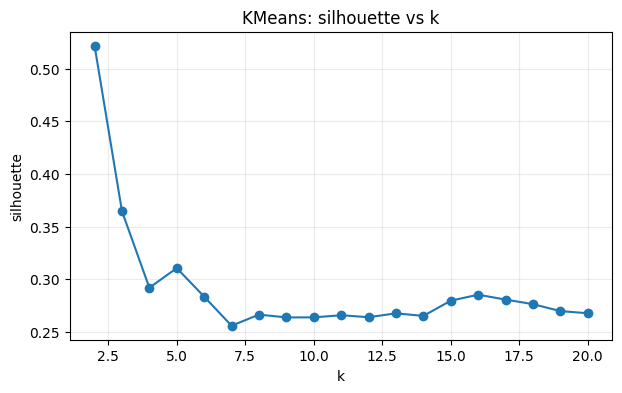

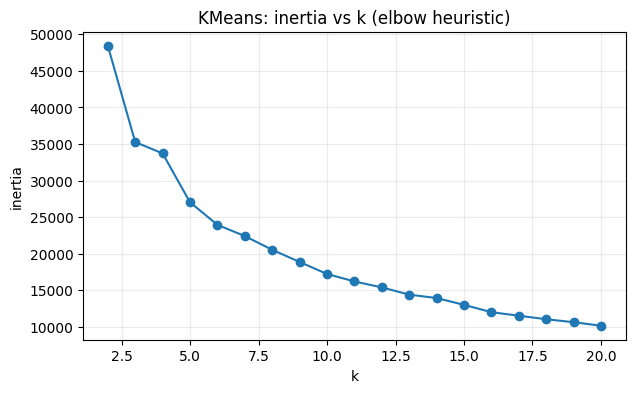

{'k': 2} 0.522
Valid DBSCAN configs: 9
{'eps': 2.0, 'min_samples': 3}


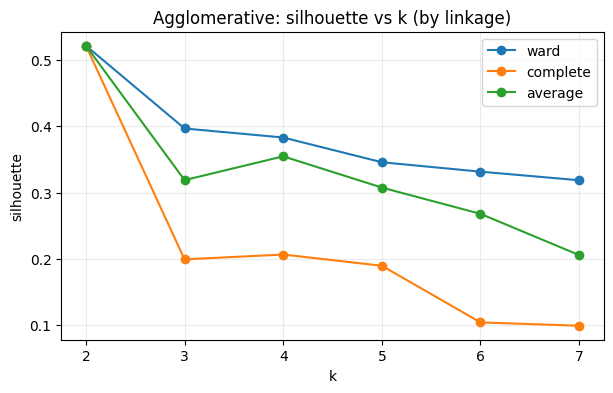

{'k': 2, 'linkage': 'ward'} 0.522
BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0
  inertia: 48425.9
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 2.0, 'min_samples': 3}
n_clusters: 2
noise_frac: 0.0  non-noise: 12000
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0
BEST AGGLOMERATIVE (by silhouette)
algo: agglomerative
params: {'k': 2, 'linkage': 'ward'}
n_clusters: 2
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0
[{'algo': 'kmeans', 'params': {'k': 2}, 'labels': array([1, 0, 0, ..., 1, 0, 1], shape=(12000,), dtype=int32), 'metrics': {'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054459, 'calinski_harabasz': 11786.95462267153}, 'inertia': 48425.90697659398, 'n_clusters': 2, 'noise_frac': 0.0}, {'algo': 'agglomerative', 'params': {'k': 2, 'linkage': 'ward'}, 'labels': array(

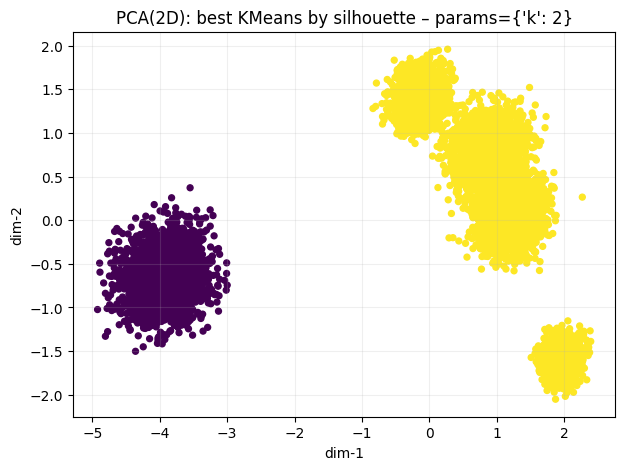




S07-hw-dataset-02.csv


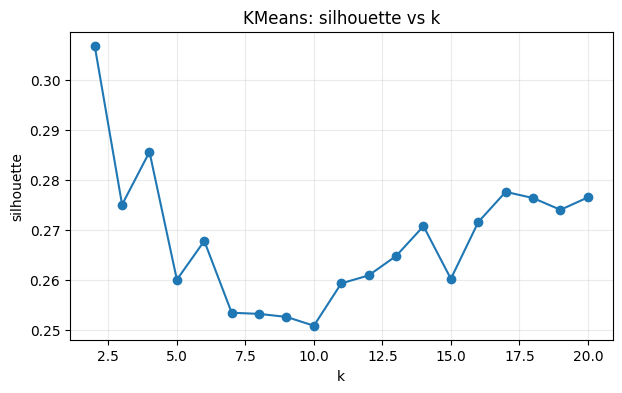

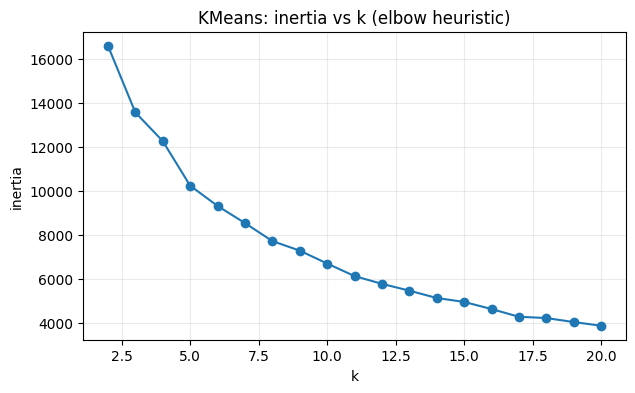

{'k': 2} 0.307
Valid DBSCAN configs: 0
No valid config found


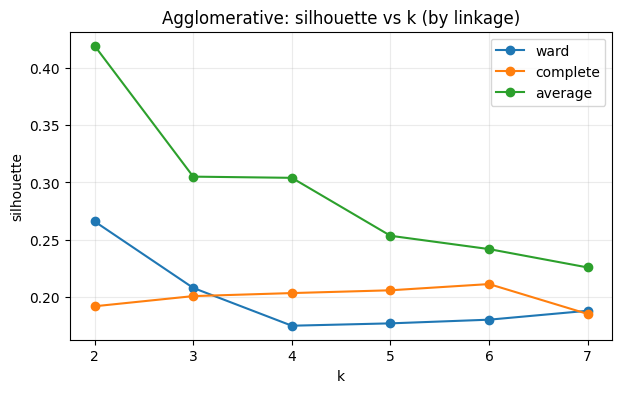

{'k': 2, 'linkage': 'average'} 0.42
BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.307
  davies_bouldin: 1.323
  calinski_harabasz: 3573.4
  inertia: 16588.5
BEST AGGLOMERATIVE (by silhouette)
algo: agglomerative
params: {'k': 2, 'linkage': 'average'}
n_clusters: 2
metrics:
  silhouette: 0.42
  davies_bouldin: 0.879
  calinski_harabasz: 395.5
[{'algo': 'kmeans', 'params': {'k': 2}, 'labels': array([0, 1, 1, ..., 1, 0, 0], shape=(8000,), dtype=int32), 'metrics': {'silhouette': 0.3068610017701601, 'davies_bouldin': 1.3234721699867644, 'calinski_harabasz': 3573.3933329348392}, 'inertia': 16588.50103229558, 'n_clusters': 2, 'noise_frac': 0.0}, {'algo': 'agglomerative', 'params': {'k': 2, 'linkage': 'average'}, 'labels': array([0, 1, 0, ..., 0, 0, 0], shape=(8000,)), 'metrics': {'silhouette': 0.41976775922231674, 'davies_bouldin': 0.8791287795996852, 'calinski_harabasz': 395.4825694831712}, 'inertia': None, 'n_clusters': 2, 'noise_frac': 0.0

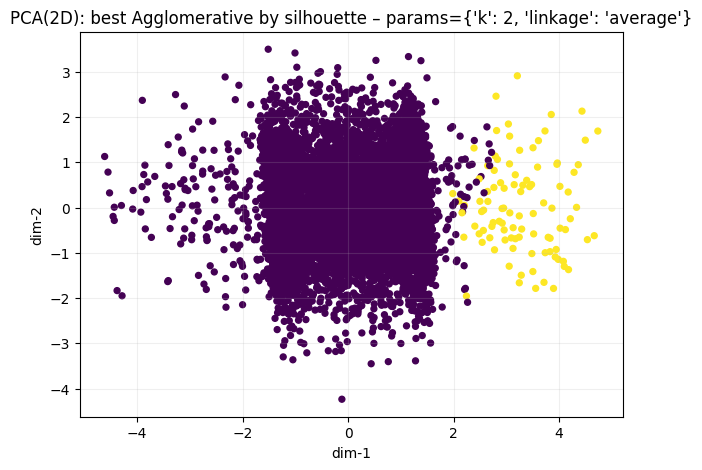




S07-hw-dataset-03.csv


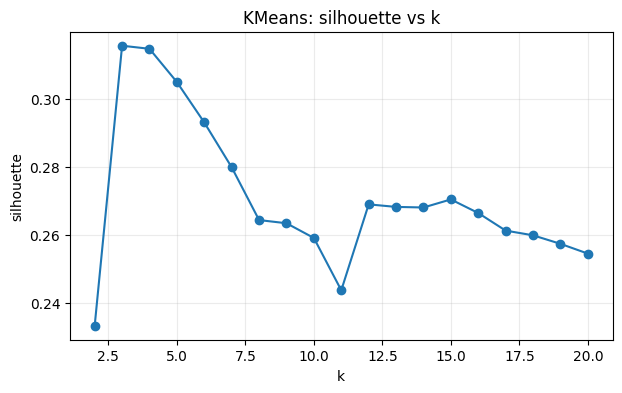

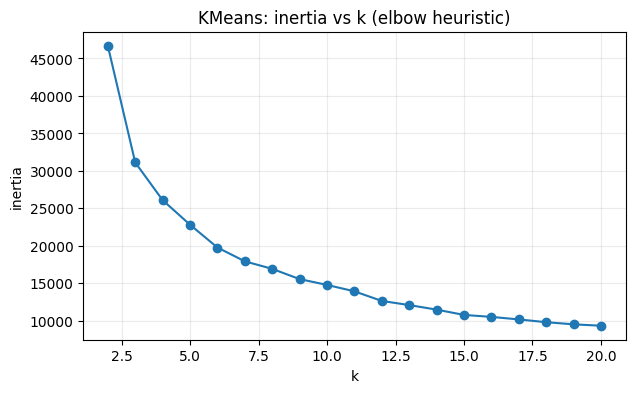

{'k': 3} 0.316
Valid DBSCAN configs: 0
No valid config found


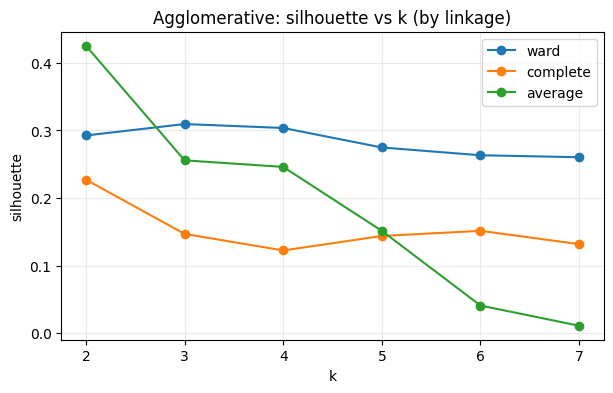

{'k': 2, 'linkage': 'average'} 0.425
BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 3}
n_clusters: 3
metrics:
  silhouette: 0.316
  davies_bouldin: 1.158
  calinski_harabasz: 6957.2
  inertia: 31123.5
BEST AGGLOMERATIVE (by silhouette)
algo: agglomerative
params: {'k': 2, 'linkage': 'average'}
n_clusters: 2
metrics:
  silhouette: 0.425
  davies_bouldin: 0.814
  calinski_harabasz: 8.9
[{'algo': 'kmeans', 'params': {'k': 3}, 'labels': array([2, 1, 1, ..., 1, 1, 1], shape=(15000,), dtype=int32), 'metrics': {'silhouette': 0.31553248183109267, 'davies_bouldin': 1.1577832240211114, 'calinski_harabasz': 6957.158106946778}, 'inertia': 31123.49744420576, 'n_clusters': 3, 'noise_frac': 0.0}, {'algo': 'agglomerative', 'params': {'k': 2, 'linkage': 'average'}, 'labels': array([0, 0, 0, ..., 0, 0, 0], shape=(15000,)), 'metrics': {'silhouette': 0.4252961244445327, 'davies_bouldin': 0.813802016581118, 'calinski_harabasz': 8.943143115556799}, 'inertia': None, 'n_clusters': 2, 'noise_frac': 0.0

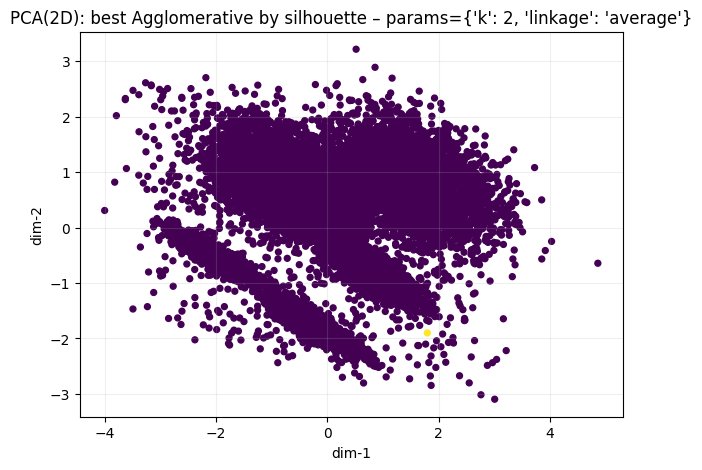

In [55]:
for df in datasets:
    print(df["file_name"])
    all_methods(df, kmeans_ks, dbscan_eps, dbscan_min_samples, agg_ks, agg_linkages)
    print("\n\n")

In [56]:
def stabilityKMeans(df, kmeans_ks):
    random_state = [42, 84, 1, 60, 101]
    File_name_df = df["file_name"]
    X_df = df["X"]
    for state in random_state:
        kmeans_results = eval_kmeans_grid(X_df, kmeans_ks, state)
        best_kmeans, best_kmeans_s = pick_best_by_silhouette(kmeans_results)
        print(best_kmeans)
stabilityKMeans(datasets[0], kmeans_ks)

{'algo': 'kmeans', 'params': {'k': 2}, 'labels': array([1, 0, 0, ..., 1, 0, 1], shape=(12000,), dtype=int32), 'metrics': {'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054459, 'calinski_harabasz': 11786.95462267153}, 'inertia': 48425.90697659398, 'n_clusters': 2, 'noise_frac': 0.0}
{'algo': 'kmeans', 'params': {'k': 2}, 'labels': array([1, 0, 0, ..., 1, 0, 1], shape=(12000,), dtype=int32), 'metrics': {'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054459, 'calinski_harabasz': 11786.95462267153}, 'inertia': 48425.90697659398, 'n_clusters': 2, 'noise_frac': 0.0}
{'algo': 'kmeans', 'params': {'k': 2}, 'labels': array([0, 1, 1, ..., 0, 1, 0], shape=(12000,), dtype=int32), 'metrics': {'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054459, 'calinski_harabasz': 11786.95462267153}, 'inertia': 48425.90697659398, 'n_clusters': 2, 'noise_frac': 0.0}
{'algo': 'kmeans', 'params': {'k': 2}, 'labels': array([0, 1, 1, ..., 0, 1, 0], shape=(12000,), d